<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/Detectron2_with_Custom_COCO_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Detectron2
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo
!pip install opencv-python

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-9d5mpzv4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-9d5mpzv4
  Resolved https://github.com/facebookresearch/fvcore.git to commit d817f01ca43612daa3923332beafb5a113148489
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65299 sha256=05ecb1a0656f79df7193a8c86f48b0d1ab8f381c34f945a548cd5035426d4ea3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n42gor9e/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=e8cd6525ac044303287de59367f86b6b92ce96587bf10ac43cd66fe2e6e97bb3
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e47

In [2]:
# Create data directory
from pathlib import Path


# Labeled data folder
data_path = Path('data/')
image_path = data_path / 'images'

if image_path.is_dir():
  print(f'[INFO] {image_path} already exists, skipping download...')
else:
  print(f'[INFO] Unable to find {image_path}, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Test data folder
test_image_path = data_path / 'test_images'

if test_image_path.is_dir():
  print(f'[INFO] {test_image_path} already exists, skipping download...')
else:
  print(f'[INFO] Unable to find {test_image_path}, creating one...')
  test_image_path.mkdir(parents=True, exist_ok=True)

[INFO] data/images already exists, skipping download...
[INFO] Unable to find data/test_images, creating one...


In [2]:
from detectron2.data.datasets import register_coco_instances


register_coco_instances("emergency_exit_sign", {}, "./data/annotations.json", "./data")

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("emergency_exit_sign")
emergency_exit_sign_metadata = MetadataCatalog.get("emergency_exit_sign")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



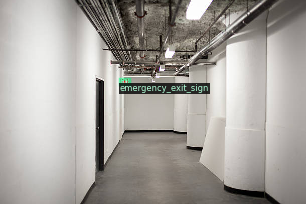

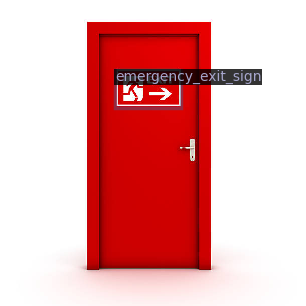

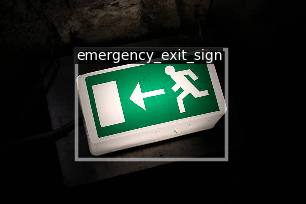

In [4]:
# Verify that data loading is correct
import random
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=emergency_exit_sign_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [5]:
# Train the model
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os


cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("emergency_exit_sign",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/07 11:41:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 188MB/s]                            

[07/07 11:41:38 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[07/07 11:41:38 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[07/07 11:41:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/07 11:41:50 d2.utils.events]:  eta: 0:02:02  iter: 19  total_loss: 1.316  loss_cls: 0.6057  loss_box_reg: 0.0005825  loss_rpn_cls: 0.6994  loss_rpn_loc: 0.01131    time: 0.4338  last_time: 0.4356  data_time: 0.0220  last_data_time: 0.0169   lr: 6.427e-05  max_mem: 2635M
[07/07 11:42:02 d2.utils.events]:  eta: 0:01:53  iter: 39  total_loss: 0.7248  loss_cls: 0.06952  loss_box_reg: 0.0009904  loss_rpn_cls: 0.5969  loss_rpn_loc: 0.01352    time: 0.4308  last_time: 0.4460  data_time: 0.0126  last_data_time: 0.0110   lr: 0.00013087  max_mem: 2635M
[07/07 11:42:10 d2.utils.events]:  eta: 0:01:43  iter: 59  total_loss: 0.5796  loss_cls: 0.08459  loss_box_reg: 0.02254  loss_rpn_cls: 0.3934  loss_rpn_loc: 0.0121    time: 0.4246  last_time: 0.3985  data_time: 0.0112  last_data_time: 0.0092   lr: 0.00019747  max_mem: 2635M
[07/07 11:42:18 d2.utils.events]:  eta: 0:01:34  iter: 79  total_loss: 0.4522  loss_cls: 0.136  loss_box_reg: 0.05275  loss_rpn_cls: 0.2192  loss_rpn_loc: 0.01692    time: 

In [29]:
# Create a predictor using the trained model
from detectron2.engine import DefaultPredictor


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.88   # set the testing threshold for this model
cfg.DATASETS.TEST = ("emergency_exit_sign", )
predictor = DefaultPredictor(cfg)

[07/07 11:55:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


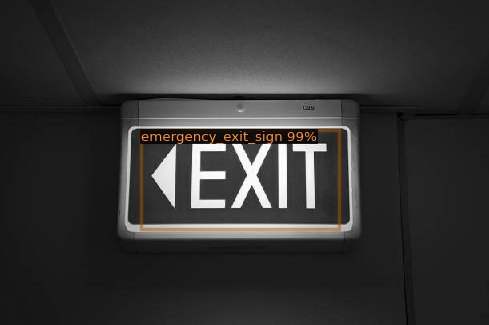

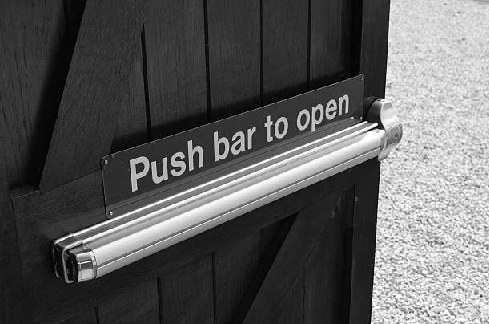

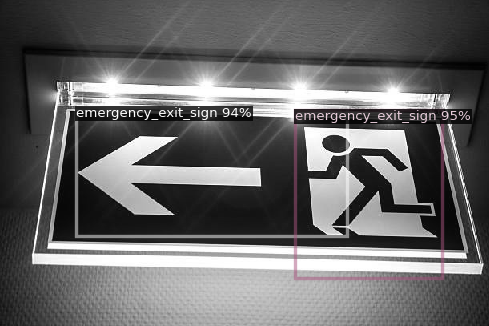

In [30]:
from detectron2.utils.visualizer import ColorMode


for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=emergency_exit_sign_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Files and directories in ' data/test_images ' :

test_image_27.jpg


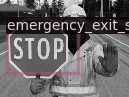


test_image_26.jpeg


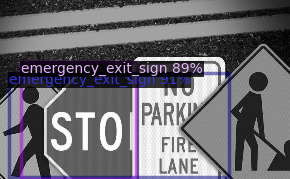


test_image_5.jpg


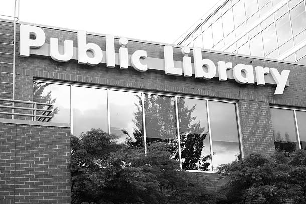


test_image_36.jpg


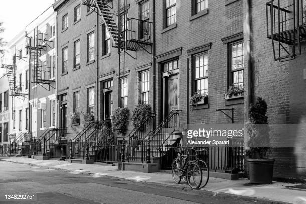


test_image_7.jpeg


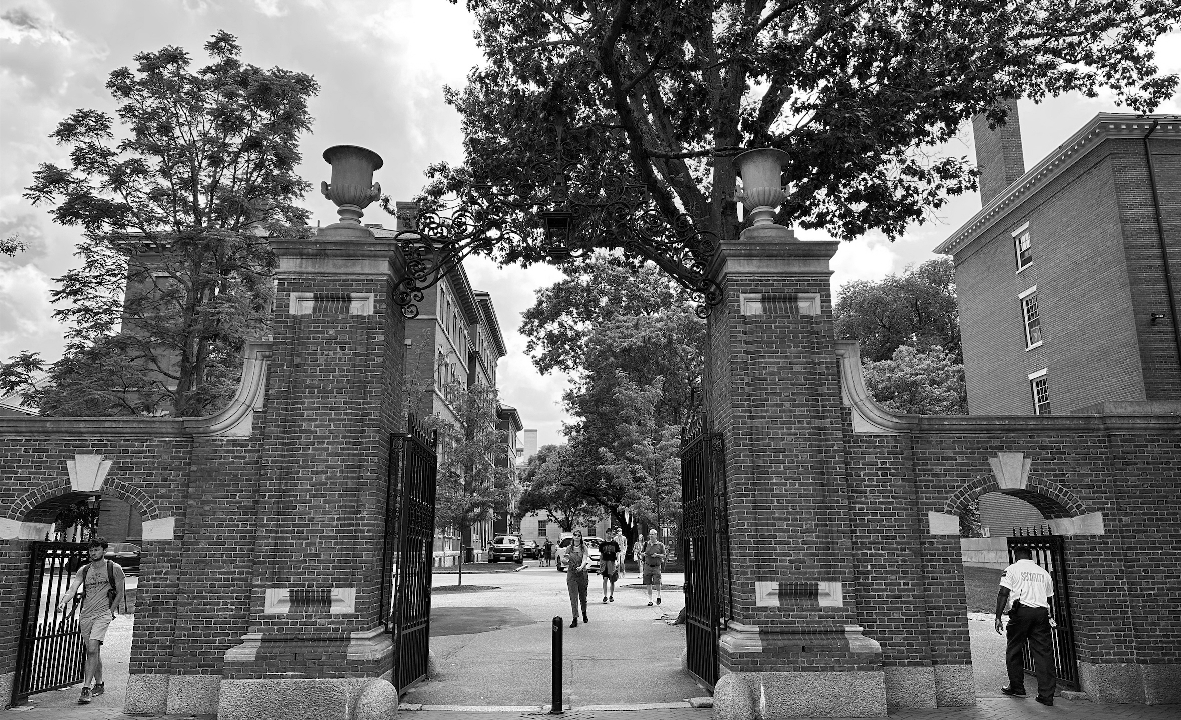


test_image_40.jpg


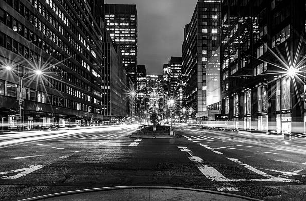


test_image_30.jpg


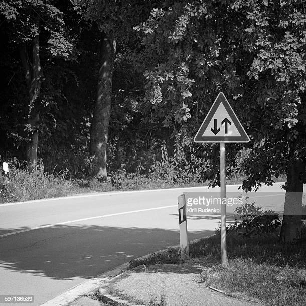


test_image_16.jpg


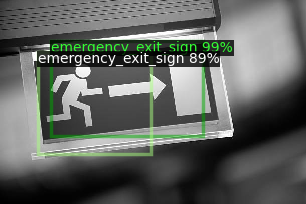


.ipynb_checkpoints
'NoneType' object has no attribute 'shape'

test_image_38.jpg


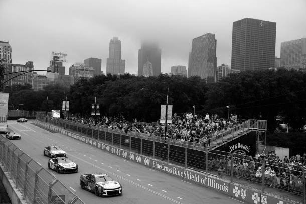


test_image_9.jpg


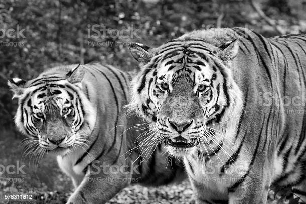


test_image_31.jpg


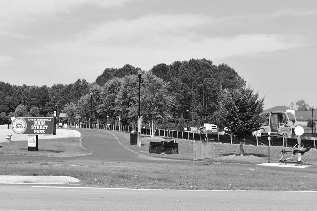


test_image_6.jpeg


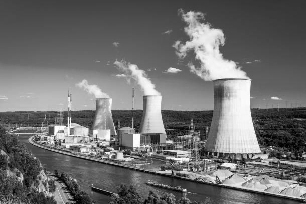


test_image_15.jpg


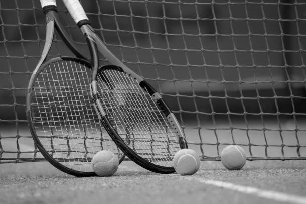


test_image_34.jpg


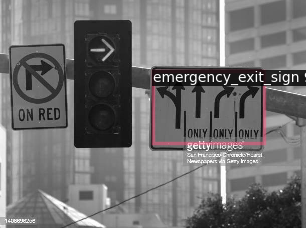


test_image_35.jpg


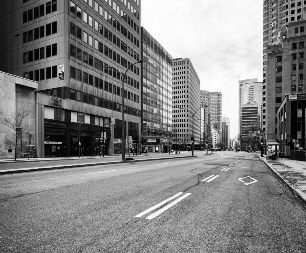


test_image_25.jpg


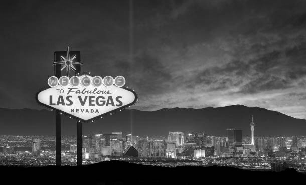


test_image_21.jpeg


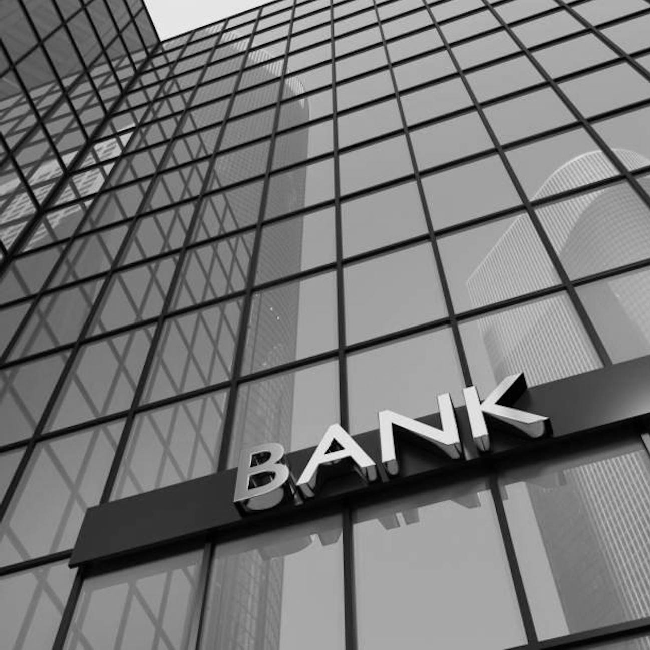


test_image_33.jpg


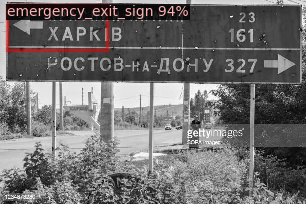


test_image_19.jpg


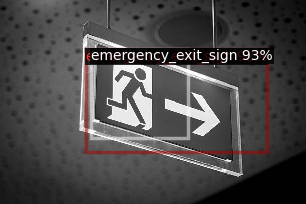


test_image_18.jpg


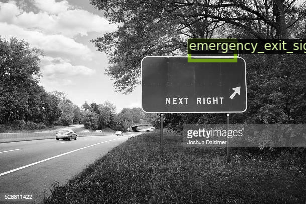


test_image_1.jpg


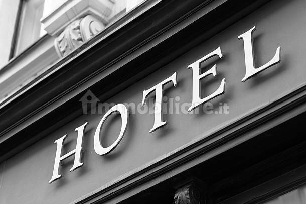


test_image_37.jpg


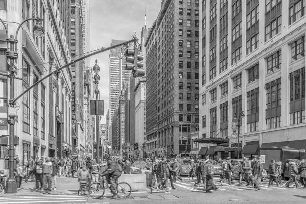


test_image_2.jpg


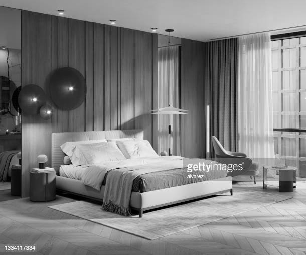


test_image_3.jpg


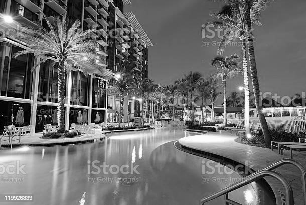


test_image_22.jpg


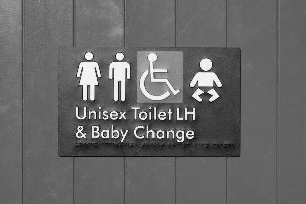


test_image_29.jpg


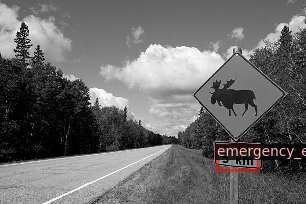


test_image_20.jpg


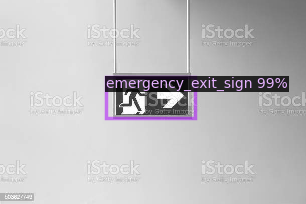


test_image_17.jpg


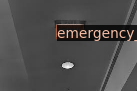


test_image_12.jpg


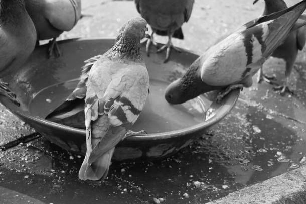


test_image_8.jpg


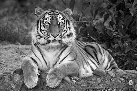


test_image_4.jpg


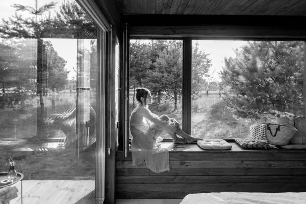


test_image_13.jpg


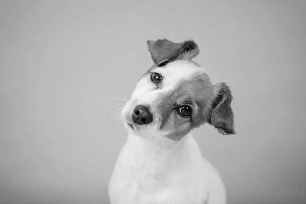


test_image_14.jpg


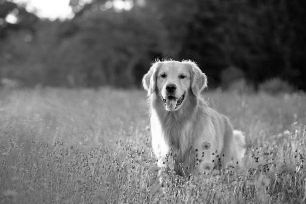


test_image_32.jpg


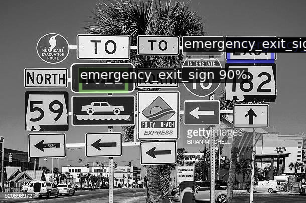


test_image_10.jpg


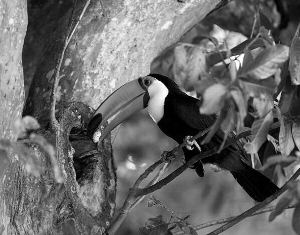


test_image_24.jpg


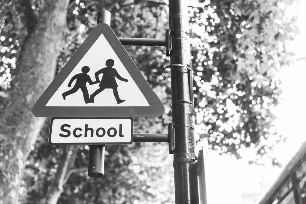


test_image_28.jpg


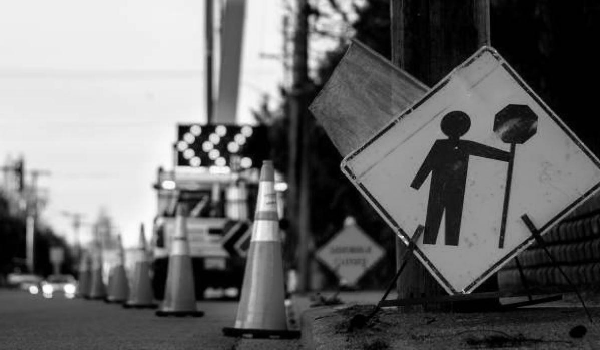


test_image_11.jpg


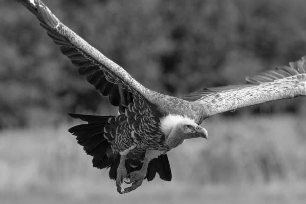


test_image_39.jpg


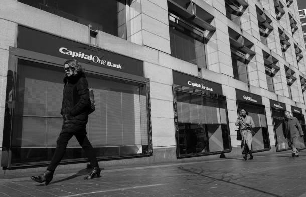


test_image_23.jpeg


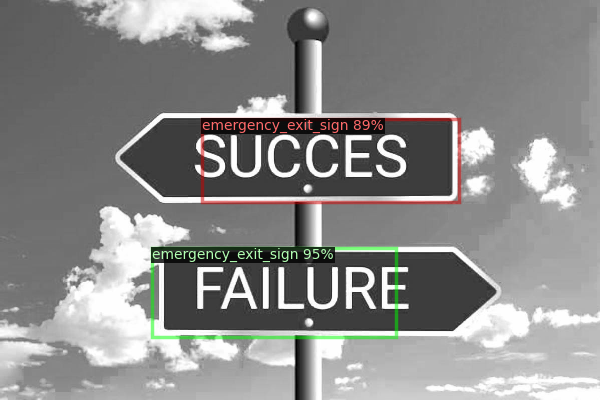

In [47]:
from detectron2.utils.visualizer import ColorMode


# import OS module
import os

# Get the list of all files and directories
test_dir_list = os.listdir(image_path)
print("Files and directories in '", image_path, "' :")
# prints all files
# print(test_dir_list)

for image in test_dir_list:
  # if image.endswith('.jpg') or image.endswith('.jpeg'):
  #   os.remove(os.path.join(image_path, image))
    print()
    print(image)
    try:
      im = cv2.imread(f'./data/test_images/{image}')
      outputs = predictor(im)
      v = Visualizer(im[:, :, ::-1],
                    metadata=emergency_exit_sign_metadata,
                    scale=0.5,
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
      )
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(v.get_image()[:, :, ::-1])
    except Exception as err:
      print(str(err))
      pass